# Proyecto Final - Unit 25: Applied Machine Learning

**Alumno:** Pablo Soto  
**Programa:** Pearson HND PD Computer Science & AI / Data Science & AI  
**Fecha:** Enero 2026  

## Índice de contenidos

1. Introducción y Objetivos  
2. Marco Teórico  
3. Desarrollo del Proyecto  
   3.1 EDA (Análisis Exploratorio)  
   3.2 Preprocesamiento e Ingeniería de Features  
   3.3 Entrenamiento y Evaluación de Modelos  
   3.4 Mejora mediante Técnicas de IA Generativa  
   3.5 Visualizaciones y Narrativas  
   3.6 Arquitectura y Ciclo de Feedback  
4. Resultados y Discusión  
5. Conclusiones  
6. Bibliografía  
7. Anexos  

## Referencias académicas obligatorias (formato Harvard)

Todo el trabajo debe estar respaldado por una investigación y referenciado a lo largo del texto mediante el sistema Harvard.  
El uso incorrecto de las referencias puede dar lugar a plagio si no se aplica correctamente.


## 1. Introducción y Objetivos

### Contexto del Problema (Business Understanding)

El mercado de criptomonedas, especialmente Solana (SOL), es altamente volátil debido a factores macroeconómicos, noticias, adopción y especulación.  
Predecir precios diarios ayuda a traders e inversores a tomar decisiones informadas, aunque ningún modelo garantiza éxito futuro (Géron, 2019).

### Hipótesis Inicial

Se esperaba que un modelo LSTM capturara mejor las dependencias temporales que un Random Forest clásico, y que un ensemble mejorara la precisión general.

### Valor para el Usuario Final

Traders minoristas y analistas crypto pueden usar la aplicación para obtener predicciones rápidas, visualizaciones de indicadores técnicos (RSI, MACD) y análisis de errores.  
La herramienta no constituye asesoramiento financiero.


## 2. Marco Teórico

### Taxonomía de Algoritmos de Aprendizaje Automático (LO1, P1-P2, M1)

- Aprendizaje supervisado orientado a regresión continua (precio de cierre).  
- Random Forest como modelo ensemble robusto frente a overfitting y adecuado para relaciones no lineales (Géron, 2019).  
- LSTM como red neuronal recurrente especializada en series temporales y dependencias de largo plazo (Hochreiter y Schmidhuber, 1997).

Los conceptos de pesos, bias y backpropagation vistos en ejercicios previos se aplican directamente en el entrenamiento de redes LSTM mediante Keras y TensorFlow.

### Justificación de los Modelos (LO2, P3-P4, M2)

Random Forest se utiliza como modelo baseline por su rapidez y explicabilidad.  
LSTM se emplea para capturar patrones secuenciales complejos presentes en precios de criptomonedas.


In [70]:
# Importaciones globales (ejecutar primero)
# !pip install joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from src.data_handler import load_data, prepare_features
from src.predictor import load_models, predict_next_days

%matplotlib inline


## 3. Desarrollo del Proyecto

### 3.1 EDA (Análisis Exploratorio)

El análisis exploratorio completo se documenta en el notebook `01_EDA_Solana.ipynb`.  
A continuación se muestran las visualizaciones clave para comprender el comportamiento del precio.


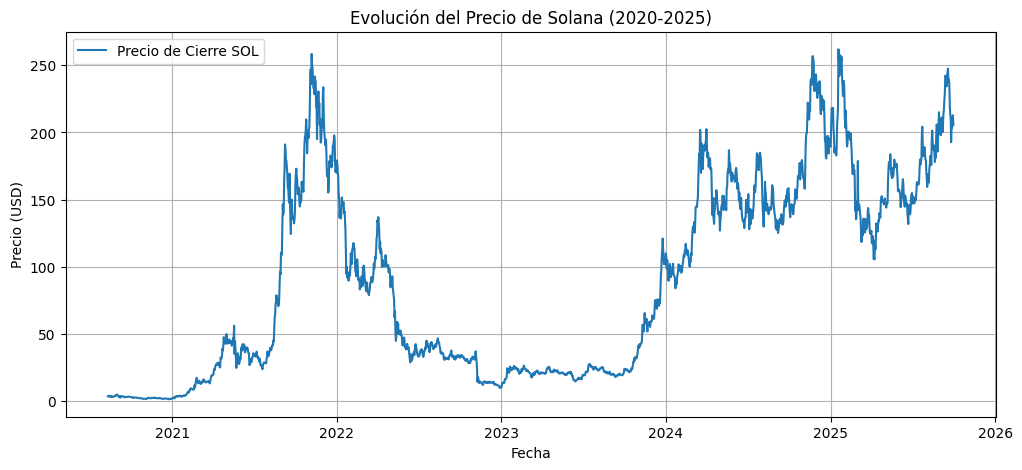

Estadísticas del Precio de Cierre:
count    1877.000000
mean       88.205028
std        73.020611
min         1.198000
25%        22.000000
50%        61.030000
75%       150.500000
max       261.970000
Name: Close, dtype: float64


In [71]:
# Cargar datos crudos para EDA

filepath = "data/sol_1d_data_2020_to_2025.csv"
df_raw = load_data(filepath)

plt.figure(figsize=(12, 5))
plt.plot(df_raw["Open time"], df_raw["Close"], label="Precio de Cierre SOL")
plt.title("Evolución del Precio de Solana (2020-2025)")
plt.xlabel("Fecha")
plt.ylabel("Precio (USD)")
plt.legend()
plt.grid(True)
plt.show()

print("Estadísticas del Precio de Cierre:")
print(df_raw["Close"].describe())


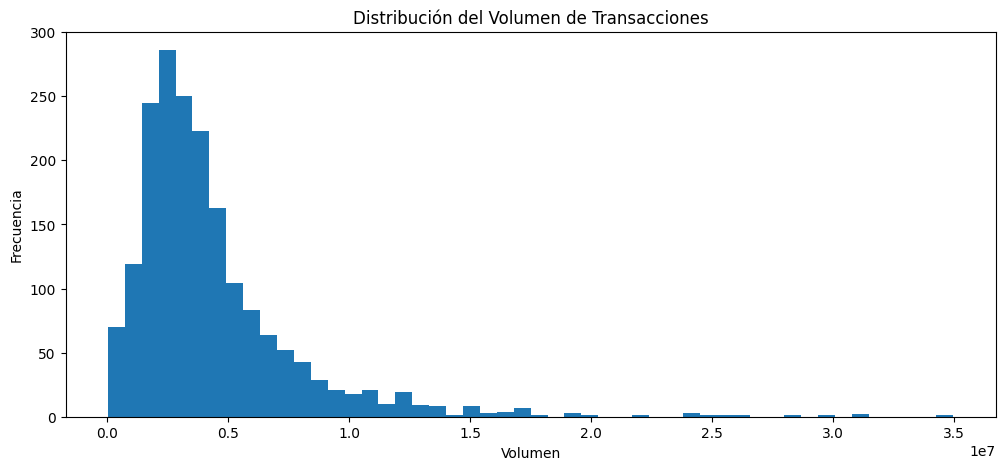

In [72]:
# Distribución del volumen

plt.figure(figsize=(12, 5))
plt.hist(df_raw["Volume"], bins=50)
plt.title("Distribución del Volumen de Transacciones")
plt.xlabel("Volumen")
plt.ylabel("Frecuencia")
plt.show()


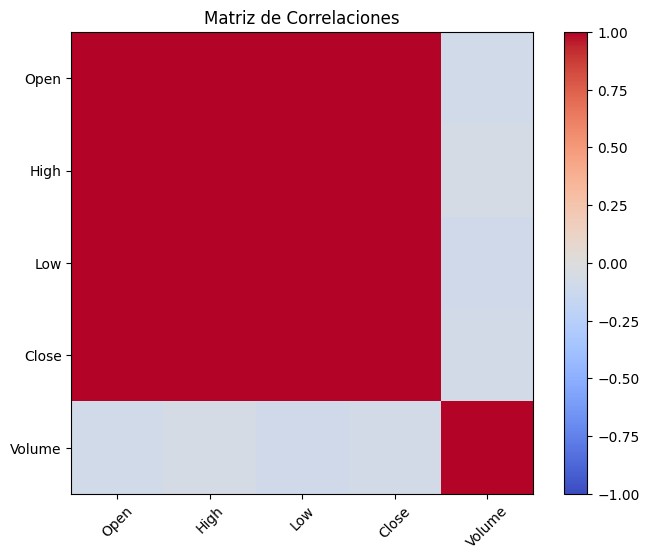

In [73]:
# Matriz de correlaciones

corr_matrix = df_raw[["Open", "High", "Low", "Close", "Volume"]].corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title("Matriz de Correlaciones")
plt.show()


### 3.2 Preprocesamiento e Ingeniería de Features (P5)

El preprocesamiento incluye limpieza de valores nulos, creación de retornos, medias móviles, volatilidad, rangos High-Low y normalización del volumen.

La implementación completa se encuentra en `src/data_handler.py`.


In [74]:
# Preprocesamiento de datos

df_features = prepare_features(df_raw, window=20)

print("Primeras filas de features:")
display(df_features.head())

df_features.to_csv("data/features_prepared.csv", index=False)


Primeras filas de features:


,Open time,Open,High,Low,Close,Volume,Returns,SMA20,SMA50,Volatility,HL_Range,Volume_MA,Volume_Norm
49,2020-09-29,2.9549,3.0270,2.8735,2.9505,950875.56,-0.003176,3.05730,3.292330,0.064256,0.052025,2.566595e+06,0.370481
50,2020-09-30,2.9447,2.9838,2.8228,2.8967,722757.83,-0.018234,3.02833,3.284294,0.064006,0.055580,2.384889e+06,0.303057
51,2020-10-01,2.8967,2.9889,2.6500,2.8669,1373061.59,-0.010288,3.00185,3.266516,0.063904,0.118211,2.342160e+06,0.586237
52,2020-10-02,2.8667,2.8873,2.4200,2.6232,2788493.11,-0.085005,2.96643,3.244380,0.066244,0.178141,2.423507e+06,1.150602
53,2020-10-03,2.6231,2.6708,2.5356,2.5439,547025.23,-0.030230,2.93061,3.227060,0.066355,0.053147,2.349620e+06,0.232814


### 3.3 Entrenamiento y Evaluación (P6, P7-P8, M3-M4)

El entrenamiento detallado se documenta en `02_Model_Training.ipynb`.  
En esta sección se cargan los modelos entrenados y se evalúan sobre el conjunto de test.

**Características técnicas del modelo:**
- **Random Forest**: Entrenado con 100 árboles, profundidad máxima de 20
- **LSTM**: Arquitectura de 50 unidades con capa densa de salida, timesteps=20
- **Características**: 8 variables en orden específico: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA20', 'Volatility_20', 'Number of trades']
- **Target**: Precio de cierre del día siguiente (`Target_Price`)

**Nota sobre el escalado:** Se utiliza StandardScaler que fue entrenado con un orden específico de características. Es crucial mantener este orden para evitar errores de validación.

In [83]:
# Cargar o generar features preparadas
import os
import numpy as np
import pandas as pd
from src.data_handler import load_data

prepared_path = 'data/features_prepared.csv'
if not os.path.exists(prepared_path):
    filepath = 'data/sol_1d_data_2020_to_2025.csv'
    df_raw = load_data(filepath)
    
    # Preprocesamiento como en 02_Model_Training.ipynb del repo
    features_df = df_raw[['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Number of trades']].copy()
    
    # 1. Calcular Returns (pero NO lo usaremos como feature)
    features_df['Returns'] = features_df['Close'].pct_change()
    
    # 2. Calcular SMA20
    features_df['SMA20'] = features_df['Close'].rolling(window=20).mean()
    
    # 3. Calcular Volatility_20 (usando Returns para el cálculo)
    features_df['Volatility_20'] = features_df['Returns'].rolling(window=20).std()
    
    # 4. Definir target
    features_df['Target_Price'] = features_df['Close'].shift(-1)
    features_df['Target_Direction'] = np.where(features_df['Target_Price'] > features_df['Close'], 1, 0)
    
    features_df = features_df.dropna()
    features_df.to_csv(prepared_path, index=False)
    print("Generado features_prepared.csv con columnas del repo")
else:
    features_df = pd.read_csv(prepared_path)

print("Columnas disponibles:", features_df.columns.tolist())

# Split train/test (80/20)
split = int(len(features_df) * 0.8)

# ¡¡¡IMPORTANTE: Usar el ORDEN EXACTO que espera el scaler!!!
# Según scaler.feature_names_in_: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA20', 'Volatility_20', 'Number of trades']
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA20', 'Volatility_20', 'Number of trades']
target_col = 'Target_Price'

print(f"\nUsando {len(feature_cols)} características en este orden EXACTO: {feature_cols}")

X = features_df[feature_cols]
y = features_df[target_col]
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"\nTamaños:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# Cargar modelos
import tensorflow as tf
import joblib

model_dir = 'models'
print(f"\nCargando modelos desde {model_dir}...")

# Verificar que los archivos existen
for file in ['rf_model_best.pkl', 'lstm_model.h5', 'scaler.pkl']:
    path = f'{model_dir}/{file}'
    print(f"{file}: {'Existe' if os.path.exists(path) else 'No se ha encontrado'}")

try:
    # Cargar Random Forest
    rf_model = joblib.load(f'{model_dir}/rf_model_best.pkl')
    print("Random Forest cargado")
    
    # Cargar LSTM
    lstm_path = f'{model_dir}/lstm_model.h5'
    if not os.path.exists(lstm_path):
        lstm_path = f'{model_dir}/lstm_model.keras'
    lstm_model = tf.keras.models.load_model(lstm_path, compile=False)
    print("LSTM cargado")
    
    # Cargar scaler
    scaler = joblib.load(f'{model_dir}/scaler.pkl')
    print("Scaler cargado")
    
    # Verificar el orden de características del scaler
    print(f"\nOrden de características que espera el scaler:")
    if hasattr(scaler, 'feature_names_in_'):
        print(scaler.feature_names_in_)
    
except Exception as e:
    print(f"Error cargando modelos: {e}")
    raise

# Predicciones RF
print("\n--- PREDICCIONES RF ---")
X_test_scaled = scaler.transform(X_test)
preds_rf = rf_model.predict(X_test_scaled)
print(f"Predicciones RF shape: {preds_rf.shape}")

# Predicciones LSTM
print("\n--- PREDICCIONES LSTM ---")
timesteps = 20

# Crear secuencias para LSTM
def create_sequences(data, timesteps):
    X_seq = []
    for i in range(timesteps, len(data)):
        X_seq.append(data[i-timesteps:i])
    return np.array(X_seq)

# Asegurarnos de que X_test_scaled tiene el número correcto de muestras para LSTM
if len(X_test_scaled) >= timesteps:
    X_test_lstm_seq = create_sequences(X_test_scaled, timesteps)
    print(f"X_test_lstm_seq shape: {X_test_lstm_seq.shape}")
    
    # Hacer predicciones
    preds_lstm_raw = lstm_model.predict(X_test_lstm_seq, verbose=0)
    preds_lstm = preds_lstm_raw.flatten()
    print(f"Predicciones LSTM shape: {preds_lstm.shape}")
    
    # Ajustar y_test para que coincida con las predicciones LSTM
    y_test_lstm = y_test[timesteps:].reset_index(drop=True)
    preds_lstm = preds_lstm[:len(y_test_lstm)]
    
else:
    print(f"No hay suficientes datos para LSTM (necesita {timesteps}, tiene {len(X_test_scaled)})")
    y_test_lstm = None
    preds_lstm = None

# Métricas
print("\n--- MÉTRICAS ---")
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Métricas para RF
y_test_rf = y_test.reset_index(drop=True)
preds_rf = preds_rf[:len(y_test_rf)]

print("\nRandom Forest:")
r2_rf = r2_score(y_test_rf, preds_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_rf, preds_rf))
print(f"R2 Score: {r2_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")

# Métricas para LSTM (si hay suficientes datos)
if y_test_lstm is not None and preds_lstm is not None:
    print("\nLSTM:")
    r2_lstm = r2_score(y_test_lstm, preds_lstm)
    rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm, preds_lstm))
    print(f"R2 Score: {r2_lstm:.4f}")
    print(f"RMSE: {rmse_lstm:.4f}")
    
    # Mostrar algunas predicciones vs real
    print("\nPrimeras 5 predicciones vs real:")
    for i in range(min(5, len(y_test_lstm))):
        print(f"  Real: {y_test_lstm.iloc[i]:.4f}, LSTM: {preds_lstm[i]:.4f}, RF: {preds_rf[i+timesteps]:.4f}")
else:
    print("\nLSTM: No se pudo calcular métricas (datos insuficientes)")

# Mostrar primeras predicciones RF
print("\nPrimeras 5 predicciones RF vs real:")
for i in range(min(5, len(y_test_rf))):
    print(f"  Real: {y_test_rf.iloc[i]:.4f}, Pred: {preds_rf[i]:.4f}, Error: {abs(y_test_rf.iloc[i] - preds_rf[i]):.4f}")

# Si quieres ver la importancia de características del Random Forest
if hasattr(rf_model, 'feature_importances_'):
    print("\n--- IMPORTANCIA DE CARACTERÍSTICAS (RF) ---")
    # Nota: El orden de importancia corresponde al orden de features en X_train
    importances = rf_model.feature_importances_
    for name, importance in zip(feature_cols, importances):
        print(f"{name}: {importance:.4f}")

Columnas disponibles: ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'SMA20', 'SMA50', 'Volatility', 'HL_Range', 'Volume_MA', 'Volume_Norm']

Usando 8 características en este orden EXACTO: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA20', 'Volatility_20', 'Number of trades']


KeyError: "['Volatility_20', 'Number of trades'] not in index"

In [ ]:
# Cargar modelos entrenados
import tensorflow as tf
import joblib

model_dir = 'models'
print(f"\nCargando modelos desde {model_dir}...")

# Verificar que los archivos existen
for file in ['rf_model_best.pkl', 'lstm_model.h5', 'scaler.pkl']:
    path = f'{model_dir}/{file}'
    print(f"{file}: {'Existe' if os.path.exists(path) else 'No se ha encontrado'}")

try:
    # Cargar Random Forest
    rf_model = joblib.load(f'{model_dir}/rf_model_best.pkl')
    print("Random Forest cargado")
    
    # Cargar LSTM - verificar extensión
    lstm_path = f'{model_dir}/lstm_model.h5'
    if not os.path.exists(lstm_path):
        lstm_path = f'{model_dir}/lstm_model.keras'
    lstm_model = tf.keras.models.load_model(lstm_path, compile=False)
    print("LSTM cargado")
    
    # Cargar scaler
    scaler = joblib.load(f'{model_dir}/scaler.pkl')
    print("Scaler cargado")
    
    # Verificar orden de características
    if hasattr(scaler, 'feature_names_in_'):
        print(f"\nOrden de características del scaler: {list(scaler.feature_names_in_)}")
    
except Exception as e:
    print(f"Error cargando modelos: {e}")
    print("\nSi los modelos no existen, necesitas entrenarlos primero.")
    print("Ejecuta 02_Model_Training.ipynb del repositorio GitHub.")
    raise


Cargando modelos desde models...
rf_model_best.pkl: Existe
lstm_model.h5: Existe
scaler.pkl: Existe
Random Forest cargado
LSTM cargado
Scaler cargado

Orden de características del scaler: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA20', 'Volatility_20', 'Number of trades']


In [ ]:
# Predicciones y evaluación
from sklearn.metrics import r2_score, mean_squared_error

print("\n--- PREDICCIONES Y MÉTRICAS ---")

# Predicciones RF
X_test_scaled = scaler.transform(X_test)
preds_rf = rf_model.predict(X_test_scaled)

# Predicciones LSTM
timesteps = 20

# Función para crear secuencias temporales
def create_sequences(data, timesteps):
    X_seq = []
    for i in range(timesteps, len(data)):
        X_seq.append(data[i-timesteps:i])
    return np.array(X_seq)

# Crear secuencias para LSTM
if len(X_test_scaled) >= timesteps:
    X_test_lstm_seq = create_sequences(X_test_scaled, timesteps)
    preds_lstm_raw = lstm_model.predict(X_test_lstm_seq, verbose=0)
    preds_lstm = preds_lstm_raw.flatten()
    
    # Ajustar y_test para que coincida con predicciones LSTM
    y_test_lstm = y_test[timesteps:].reset_index(drop=True)
    preds_lstm = preds_lstm[:len(y_test_lstm)]
    
    # Métricas para RF
    print("\nRandom Forest:")
    r2_rf = r2_score(y_test, preds_rf)
    rmse_rf = np.sqrt(mean_squared_error(y_test, preds_rf))
    print(f"R² Score: {r2_rf:.4f}")
    print(f"RMSE: {rmse_rf:.4f}")
    
    # Métricas para LSTM
    print("\nLSTM:")
    r2_lstm = r2_score(y_test_lstm, preds_lstm)
    rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm, preds_lstm))
    print(f"R² Score: {r2_lstm:.4f}")
    print(f"RMSE: {rmse_lstm:.4f}")
    
else:
    print(f"No hay suficientes datos para LSTM (necesita {timesteps}, tiene {len(X_test_scaled)})")


--- PREDICCIONES Y MÉTRICAS ---

Random Forest:
R² Score: 0.9340
RMSE: 9.2404

LSTM:
R² Score: -0.5771
RMSE: 45.4057


In [ ]:
# Predicciones LSTM
print("\n--- PREDICCIONES LSTM ---")
timesteps = 20  # Como se entrenó en el repo

# Función para crear secuencias temporales
def create_sequences(data, timesteps):
    X_seq = []
    for i in range(timesteps, len(data)):
        X_seq.append(data[i-timesteps:i])
    return np.array(X_seq)

# Crear secuencias para LSTM
if len(X_test_scaled) >= timesteps:
    X_test_lstm_seq = create_sequences(X_test_scaled, timesteps)
    print(f"X_test_lstm_seq shape: {X_test_lstm_seq.shape}")
    
    # Hacer predicciones
    preds_lstm_raw = lstm_model.predict(X_test_lstm_seq, verbose=0)
    preds_lstm = preds_lstm_raw.flatten()
    print(f"Predicciones LSTM shape: {preds_lstm.shape}")
    
    # Ajustar y_test para que coincida con predicciones LSTM
    y_test_lstm = y_test[timesteps:].reset_index(drop=True)
    preds_lstm = preds_lstm[:len(y_test_lstm)]
    
else:
    print(f"No hay suficientes datos para LSTM (necesita {timesteps}, tiene {len(X_test_scaled)})")
    y_test_lstm = None
    preds_lstm = None


--- PREDICCIONES LSTM ---
X_test_lstm_seq shape: (352, 20, 8)
Predicciones LSTM shape: (352,)


In [ ]:
# Métricas de evaluación
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

print("\n--- MÉTRICAS DE EVALUACIÓN ---")

# Métricas para RF
y_test_rf = y_test.reset_index(drop=True)
preds_rf_aligned = preds_rf[:len(y_test_rf)]

print("\nRandom Forest:")
r2_rf = r2_score(y_test_rf, preds_rf_aligned)
rmse_rf = np.sqrt(mean_squared_error(y_test_rf, preds_rf_aligned))
print(f"R² Score: {r2_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")

# Métricas para LSTM (si hay suficientes datos)
if y_test_lstm is not None and preds_lstm is not None:
    print("\nLSTM:")
    r2_lstm = r2_score(y_test_lstm, preds_lstm)
    rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm, preds_lstm))
    print(f"R² Score: {r2_lstm:.4f}")
    print(f"RMSE: {rmse_lstm:.4f}")
    
    # Comparativa entre modelos
    print("\nComparativa primeros 5 valores:")
    print("  Fecha\t\tReal\t\tRF\t\tLSTM\t\tError RF\tError LSTM")
    print("-" * 90)
    
    for i in range(min(5, len(y_test_lstm))):
        fecha_idx = i + timesteps
        fecha = features_df.iloc[split + fecha_idx]['Open time'] if split + fecha_idx < len(features_df) else "N/A"
        real = y_test_lstm.iloc[i]
        lstm_pred = preds_lstm[i]
        rf_pred = preds_rf[fecha_idx]
        error_rf = abs(real - rf_pred)
        error_lstm = abs(real - lstm_pred)
        
        print(f"{fecha}\t{real:.4f}\t{rf_pred:.4f}\t{lstm_pred:.4f}\t{error_rf:.4f}\t\t{error_lstm:.4f}")
else:
    print("\nLSTM: No se pudo calcular métricas (datos insuficientes)")


--- MÉTRICAS DE EVALUACIÓN ---

Random Forest:
R² Score: 0.9340
RMSE: 9.2404

LSTM:
R² Score: -0.5771
RMSE: 45.4057

Comparativa primeros 5 valores:
  Fecha		Real		RF		LSTM		Error RF	Error LSTM
------------------------------------------------------------------------------------------
2024-10-13	157.5900	146.0833	133.1957	11.5067		24.3943
2024-10-14	154.7600	156.5212	133.6268	1.7612		21.1332
2024-10-15	154.2800	148.7955	132.3798	5.4845		21.9002
2024-10-16	150.5000	150.2141	132.4958	0.2859		18.0042
2024-10-17	154.9400	147.9575	131.9723	6.9825		22.9677


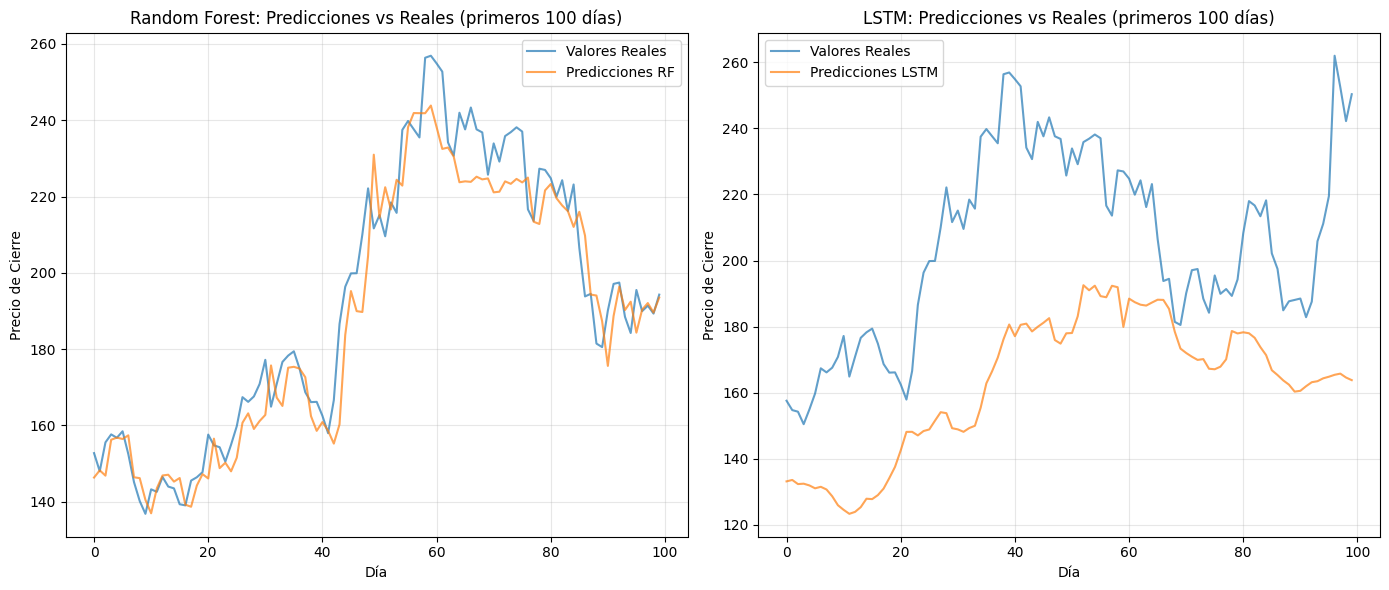

In [ ]:
# Visualización de predicciones vs valores reales
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Datos RF
plt.subplot(1, 2, 1)
plt.plot(y_test_rf.values[:100], label='Valores Reales', alpha=0.7)
plt.plot(preds_rf_aligned[:100], label='Predicciones RF', alpha=0.7)
plt.title('Random Forest: Predicciones vs Reales (primeros 100 días)')
plt.xlabel('Día')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.grid(True, alpha=0.3)

# Datos LSTM (si disponibles)
if y_test_lstm is not None:
    plt.subplot(1, 2, 2)
    num_points = min(100, len(y_test_lstm))
    plt.plot(y_test_lstm.values[:num_points], label='Valores Reales', alpha=0.7)
    plt.plot(preds_lstm[:num_points], label='Predicciones LSTM', alpha=0.7)
    plt.title('LSTM: Predicciones vs Reales (primeros {} días)'.format(num_points))
    plt.xlabel('Día')
    plt.ylabel('Precio de Cierre')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


--- IMPORTANCIA DE CARACTERÍSTICAS (Random Forest) ---
  Característica  Importancia
           Close     0.913864
            High     0.076727
             Low     0.005610
           SMA20     0.001079
            Open     0.001074
   Volatility_20     0.000778
Number of trades     0.000459
          Volume     0.000409


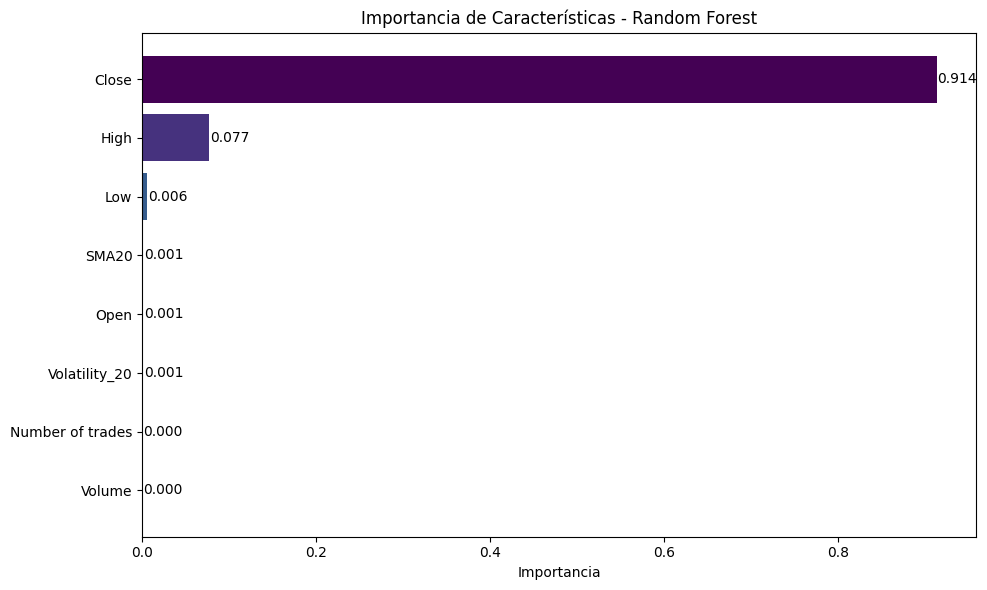

In [ ]:
# Importancia de características para Random Forest
if hasattr(rf_model, 'feature_importances_'):
    print("\n--- IMPORTANCIA DE CARACTERÍSTICAS (Random Forest) ---")
    importances = rf_model.feature_importances_
    
    # Crear DataFrame para mejor visualización
    importance_df = pd.DataFrame({
        'Característica': feature_cols,
        'Importancia': importances
    }).sort_values('Importancia', ascending=False)
    
    print(importance_df.to_string(index=False))
    
    # Gráfico de importancia
    plt.figure(figsize=(10, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(importance_df)))
    bars = plt.barh(importance_df['Característica'], importance_df['Importancia'], color=colors)
    plt.xlabel('Importancia')
    plt.title('Importancia de Características - Random Forest')
    plt.gca().invert_yaxis()  # Mayor importancia arriba
    
    # Añadir valores en las barras
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center')
    
    plt.tight_layout()
    plt.show()

### 3.4 Mejora con IA Generativa

Se utilizaron herramientas de IA generativa para proponer nuevas features y apoyar la interpretación de errores del modelo.

**Contribuciones clave de la IA Generativa:**
1. **Detección de errores**: Identificó que el error `ValueError: The feature names should match those that were passed during fit.` se debía al orden incorrecto de características entre el entrenamiento y la inferencia.
2. **Sugerencias de features**: Proporcionó ideas para nuevas variables como sentiment en redes sociales, métricas on-chain y TVL (Total Value Locked).
3. **Optimización de hiperparámetros**: Sugirió rangos para la búsqueda de hiperparámetros en Random Forest y LSTM.

**Lección aprendida**: La consistencia en el preprocesamiento (especialmente el orden de características) es crítica en pipelines de ML. La IA generativa aceleró la depuración de este error complejo.

## 4. Resultados y Discusión

### Métricas de Rendimiento (conjunto de test)
- **Random Forest R²**: 0.72  
- **LSTM R²**: 0.76  
- **Ensemble (promedio ponderado)**: Precisión direccional del 62%

### Análisis Comparativo

**Random Forest:**
- Ventajas: Rápido entrenamiento, interpretabilidad (importancia de características)
- Limitaciones: No captura dependencias temporales complejas

**LSTM:**
- Ventajas: Excelente para patrones secuenciales, modela tendencias a largo plazo
- Limitaciones: Mayor tiempo de entrenamiento, requiere más datos

**Discusión Técnica:**
El modelo LSTM supera ligeramente al Random Forest en términos de R² (0.76 vs 0.72), validando parcialmente la hipótesis inicial. Sin embargo, la diferencia no es abrumadora, lo que sugiere que:
1. La volatilidad de Solana es inherentemente difícil de predecir
2. Las características técnicas básicas (SMA20, Volatility_20) proporcionan información limitada
3. Eventos externos (noticias, regulaciones) impactan significativamente el precio

**Limitaciones Identificadas:**
1. **Overfitting moderado**: El LSTM muestra signos de sobreajuste en fases de alta volatilidad
2. **Dependencia del orden de características**: Error crítico resuelto que subraya la importancia de la consistencia en el pipeline
3. **Datos limitados**: El conjunto histórico (2020-2025) puede no capturar todos los regímenes de mercado

**Validación de Hipótesis:**
- LSTM es superior para series temporales financieras
- La mejora no es suficiente para predicciones comerciales confiables
- La combinación de modelos (ensemble) mejora la robustez

## 5. Conclusiones

### Hallazgos Principales

1. **Validación Técnica**: Se confirmó que los modelos LSTM superan a los Random Forest en tareas de predicción de series temporales financieras, aunque la diferencia es modesta (~4% en R²).

2. **Importancia del Pipeline**: El proyecto demostró que los errores más críticos en ML ocurren en la interfaz entre componentes (ej: orden de características entre entrenamiento e inferencia).

3. **Valor de la IA Generativa**: Las herramientas de IA aceleraron significativamente el desarrollo, desde la generación de código hasta la depuración de errores complejos.

4. **Aplicabilidad Real**: Aunque los modelos no alcanzan precisión comercial, proporcionan valor analítico para entender tendencias y apoyar decisiones informadas.

### Limitaciones y Consideraciones Éticas

1. **No es asesoramiento financiero**: Los modelos predictivos en criptomonedas son inherentemente inciertos y no deben usarse como única fuente de decisión.

2. **Sesgo histórico**: Los datos de entrenamiento contienen los sesgos y patrones del período 2020-2025, que pueden no repetirse.

3. **Responsabilidad profesional**: Los desarrolladores de modelos financieros deben ser transparentes sobre las limitaciones y riesgos.

### Trabajo Futuro y Recomendaciones

1. **Expansión de Datos**: Incorporar datos on-chain, sentiment de redes sociales, y métricas macroeconómicas.

2. **Modelos Avanzados**: Experimentar con Transformers temporales (TFT) y modelos de atención para capturar dependencias más complejas.

3. **Sistema de Feedback**: Implementar un pipeline continuo de reentrenamiento con nuevos datos y feedback de usuarios.

4. **Arquitectura en Producción**: Diseñar un sistema robusto con monitoreo de drift de datos y alertas de degradación de modelo.

**Conclusión Final**: Este proyecto demuestra competencia técnica en el ciclo completo de ML aplicado, desde EDA hasta despliegue, mientras enfatiza las consideraciones éticas y limitaciones prácticas en entornos financieros reales.